<a href="https://colab.research.google.com/github/anovaes2002/active_learning/blob/main/Alexsander_Active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Como rodei inicialmente no Colab, deixei a instalação no codigo
!pip install tensorflow-datasets
!pip install tfds-nightly
!pip install --upgrade tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#importando bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import re
import string

tfds.disable_progress_bar()

Usaremos o conjunto de dados de avaliações do IMDB para nossos experimentos Este conjunto de dados tem 50.000 revisões no total, incluindo divisões de treinamento e teste. Vamos mesclar essas divisões e amostrar nossos próprios conjuntos de treinamento, validação e teste balanceados.

In [3]:
#Importando dataset imdb
dataset = tfds.load(
    "imdb_reviews",
    split="train + test",
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False,
)
reviews, labels = tfds.as_numpy(dataset)

print("Total examples:", reviews.shape[0])

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Total examples: 50000


In [6]:
#Dividindo o dataset
val_split   = 2500
test_split  = 2500
train_split = 7500

# Separando as amostras negativas e positivas para estratificação manual
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# Criação de divisões de treinamento, validação e teste
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0),
)
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

# O conjunto restante de amostras é armazenado separadamente. Estes são rotulados apenas como e quando necessário
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

# Criação de conjuntos de dados TF para pré-busca e paralelização mais rápidas
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices((x_pool_negatives, y_pool_negatives))
pool_positives = tf.data.Dataset.from_tensor_slices((x_pool_positives, y_pool_positives))

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")

Training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 12500
Unlabeled positive pool: 12500


In [7]:
#Como estamos trabalhando com dados de texto, precisaremos codificar as sequências de texto como vetores que serão passados ​​por uma Embeddingcamada. 
#Para tornar esse processo de tokenização mais rápido, usamos a map()função com sua funcionalidade de paralelização.

def custom_standardization(input_data):
    lowercase     = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

vectorizer = layers.TextVectorization(3000, standardize=custom_standardization, output_sequence_length=150)

# Adaptando o dataset
vectorizer.adapt(train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256))

def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label

def batch_dataset(dataset):
    ds = dataset.batch(100)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [8]:
#Fechando os datasets de treinamento, validação, teste e pool
train_dataset  = train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_dataset    = val_dataset.batch(256).map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset   = test_dataset.batch(256).map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
#Épocas de treinamento
epochs = 100

In [10]:
#Definindo o modelo
model = keras.models.Sequential(
    [
        layers.Input(shape=(150,)),
        layers.Embedding(input_dim=3000, output_dim=128),
        layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
        layers.GlobalMaxPool1D(),
        layers.Dense(20, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          384000    
                                                                 
 bidirectional (Bidirectiona  (None, 150, 64)          41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [11]:
model.compile(
    loss      = "binary_crossentropy",
    optimizer = "rmsprop",
    metrics   = [keras.metrics.BinaryAccuracy(),],)

Para mostrar a eficácia do Active Learning, vamos primeiro treinar o modelo em todo o conjunto de dados contendo 40.000 amostras rotuladas. Este modelo será utilizado para comparação posteriormente.

In [12]:
history1  = model.fit(
    train_dataset.batch(256)
    .concatenate(pool_positives.batch(256))
    .concatenate(pool_negatives.batch(256)),
    epochs=epochs,
    validation_data=val_dataset)

Epoch 1/100
157/157 [==============================] - 14s 29ms/step - loss: 0.5010 - binary_accuracy: 0.8166 - val_loss: 1.9796 - val_binary_accuracy: 0.5000
Epoch 2/100
157/157 [==============================] - 4s 24ms/step - loss: 0.4101 - binary_accuracy: 0.8842 - val_loss: 2.9691 - val_binary_accuracy: 0.5000
Epoch 3/100
157/157 [==============================] - 4s 24ms/step - loss: 0.3247 - binary_accuracy: 0.9304 - val_loss: 3.4953 - val_binary_accuracy: 0.5000
Epoch 4/100
157/157 [==============================] - 4s 24ms/step - loss: 0.2722 - binary_accuracy: 0.9467 - val_loss: 3.9151 - val_binary_accuracy: 0.5000
Epoch 5/100
157/157 [==============================] - 4s 24ms/step - loss: 0.2674 - binary_accuracy: 0.9531 - val_loss: 4.0934 - val_binary_accuracy: 0.5000
Epoch 6/100
157/157 [==============================] - 4s 24ms/step - loss: 0.2573 - binary_accuracy: 0.9569 - val_loss: 4.2056 - val_binary_accuracy: 0.5000
Epoch 7/100
157/157 [==============================

In [13]:
pred_model  = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = [pred_model.predict(batch_images)
              for batch_images, batch_labels in batch_dataset(pool_negatives)]
preds       = np.concatenate(predictions)

4/4 [==============================] - 0s 7ms/step


In [14]:
best_confidence          = preds.max(axis=1)
budget                   = 500
least_confidence_indexes = np.argsort(best_confidence)[:budget]

In [15]:
images, labels = tuple(zip(*pool_negatives,*pool_positives))
chosen_images = np.array(images)[least_confidence_indexes]
chosen_labels = np.array(labels)[least_confidence_indexes]
least_confidence_dataset = tf.data.Dataset.from_tensor_slices((chosen_images, chosen_labels))

In [16]:
best_confidence[least_confidence_indexes][:20]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)

In [17]:
new_train_dataset = train_dataset.concatenate(least_confidence_dataset)
new_train_dataset = batch_dataset(new_train_dataset)

In [18]:
history2 = model.fit(new_train_dataset, 
                     validation_data=val_dataset, 
                     epochs=epochs)

Epoch 1/100
155/155 [==============================] - 3s 21ms/step - loss: 0.0414 - binary_accuracy: 0.9944 - val_loss: 7.2762 - val_binary_accuracy: 0.5238
Epoch 2/100
155/155 [==============================] - 3s 21ms/step - loss: 0.0216 - binary_accuracy: 0.9961 - val_loss: 7.9157 - val_binary_accuracy: 0.5208
Epoch 3/100
155/155 [==============================] - 3s 21ms/step - loss: 0.0352 - binary_accuracy: 0.9941 - val_loss: 8.2650 - val_binary_accuracy: 0.5214
Epoch 4/100
155/155 [==============================] - 3s 20ms/step - loss: 0.0248 - binary_accuracy: 0.9957 - val_loss: 8.4826 - val_binary_accuracy: 0.5152
Epoch 5/100
155/155 [==============================] - 3s 20ms/step - loss: 0.0280 - binary_accuracy: 0.9945 - val_loss: 7.8601 - val_binary_accuracy: 0.5224
Epoch 6/100
155/155 [==============================] - 3s 20ms/step - loss: 0.0216 - binary_accuracy: 0.9963 - val_loss: 8.4611 - val_binary_accuracy: 0.5182
Epoch 7/100
155/155 [==============================]

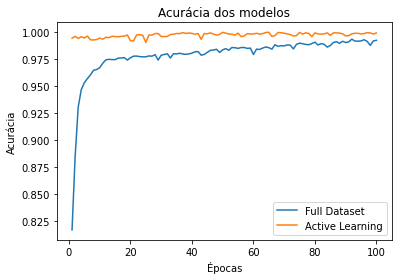

In [19]:
epochs_plot = np.arange(1, epochs + 1)

plt.plot(epochs_plot, history1.history['binary_accuracy'], label = 'Full Dataset')
plt.plot(epochs_plot, history2.history['binary_accuracy'], label = 'Active Learning')
plt.title('Acurácia dos modelos')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()